In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import owlready2 as owl
from owlready2 import *
import types
owlready2.reasoning.JAVA_MEMORY = 200000

#import scipy
#from scipy.spatial import ConvexHull
#import cdd
#from cdd import RepType, Matrix, Polyhedron
#from fractions import Fraction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation




device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [2]:
# dir = '/Users/victorlacerda/Documents/VSCode/ELHFaithfulness/NormalizedOntologies/goslimyeast.xml.owl'
# dir = '/Users/victorlacerda/Documents/VSCode/ELHFaithfulness/NormalizedOntologies/galennorm.xml.owl'
# dir = '/Users/victorlacerda/Documents/VSCode/ELHFaithfulness/NormalizedOntologies/gonorm.xml.owl'
# dir = '/Users/victorlacerda/Desktop/toyontology.owl'
dir = '/Users/victorlacerda/Documents/VSCode/ELHFaithfulness/NormalizedOntologies/family_ontology.owl'

In [3]:
'''
Class for creating entities to
populate the creation of the
canonical models.

The .name attribute is used to
create a single representation
for concepts like A and B / 
B and A, as they are the same.
'''

class CanonicalModelElements:

    concept_names = {}
    concept_intersections = {}
    concept_restrictions = {}
    all_concepts = {}

    def __init__(self, concept):
        self.concept = concept
        self.name = self.get_name()
        self.get_element_dict()

    def get_name(self):
        
        if type(self.concept) == ThingClass:
            return self.concept.name

        elif type(self.concept) == Restriction:
            return 'exists_' + self.concept.property.name + '.' + self.concept.value.name
        
        else:
            return 'And_' + ''.join(sorted(self.concept.Classes[0].name + self.concept.Classes[1].name)) # The name is sorted to avoid that (e.g) (A \and B) and (B \and A) are treated as different concepts
        
    def get_element_dict(self):

        if type(self.concept) == ThingClass:
            CanonicalModelElements.concept_names[self.name] = self
            CanonicalModelElements.all_concepts[self.name] = self

        elif type(self.concept) == Restriction:
            CanonicalModelElements.concept_restrictions[self.name] = self
            CanonicalModelElements.all_concepts[self.name] = self

        elif type(self.concept) == And:
            CanonicalModelElements.concept_intersections[self.name] = self
            CanonicalModelElements.all_concepts[self.name] = self
def get_canonical_model_elements(concept_names_iter, role_names_iter, ontology, restrict_language = True):
    
    onto = ontology
    top = owl.Thing
    #bottom = owl.Nothing

    CanonicalModelElements(top)
    #CanonicalModelElements(bottom)

    for concept_name in concept_names_iter:
        
        CanonicalModelElements(concept_name)

        if restrict_language == False:

            for concept_name2 in concept_names_iter:
        
                with onto:
                    gca = GeneralClassAxiom(concept_name & concept_name2)
                    gca.is_a.append(concept_name & concept_name2)
            
                CanonicalModelElements(gca.left_side)

    print('')
    print('===========================================================================================================')
    print('All Concept Names and Concept Intersections have been preprocessed for the creation of the canonical model.')
    print('===========================================================================================================')

    concept_names_iter.append(top)
    #concept_names_iter.append(bottom)

    if restrict_language == False:

        for role_name in role_names_iter:
            for concept_name in concept_names_iter:
                with onto:
                    gca = GeneralClassAxiom(role_name.some(concept_name))
                    gca.is_a.append(role_name.some(concept_name))

                CanonicalModelElements(gca.left_side)
    
    else:

        for role_name in role_names_iter:
            with onto:
                gca = GeneralClassAxiom(role_name.some(owl.Thing))
                gca.is_a.append(role_name.some(owl.Thing))

                CanonicalModelElements(gca.left_side)
            
    print('')
    print('All restrictions have been preprocessed for the creation of the canonical model.')
'''
The main class for creating the canonical model for the ontology.

The canonical model is stored in dictionaries available as class variables 'concept_canonical_interpretation'
and 'role_canonical_interpretation'. 

Args:
    concept_names_dict: a dictionary stored in the CanonicalModelElement class.
    concept_intersection_dict: a dictionary stored in the CanonicalModelElement class.
    concept_restrictions_dict: a dictionary stored in the CanonicalModelElement class.
    all_concepts_dict: a dictionary stored in the CanonicalModelElement class.
    role_names_iter (list): a list containing all role names in the loaded ontology.
'''

class CanonicalModel:

    concept_canonical_interpretation = {}
    role_canonical_interpretation = {}

    def __init__(self, concept_names_dict, concept_intersections_dict, concept_restrictions_dict, all_concepts_dict, role_names_iter):
        
        self.domain = all_concepts_dict
        self.concept_names_dict = concept_names_dict
        self.concept_restrictions_dict = concept_restrictions_dict
        self.concept_intersections_dict = concept_intersections_dict

        self.role_names_iter = role_names_iter

        self.concept_canonical_interp = self.get_concept_name_caninterp() # These are only used to build the concept_canonical_interpretation and role_canonical_interpretation class attributes
        self.role_canonical_interp = self.get_role_name_caninterp()       # The functions do not return anything, they just update their corresponding class variables 

    def get_concept_name_caninterp(self):

        # The variable concept is a string containing the name of an element of the domain of the canonical model
        # The key to the concept_names_dict variable corresponds to concept.name
        # This name can be used to access the concept in owlready2's format

        for concept in self.concept_names_dict.keys():

            CanonicalModel.concept_canonical_interpretation[concept] = []
            superclasses = self.domain[concept].concept.ancestors(include_self=True, include_constructs=True) # The self.domain[concept] is used to access the CanonicalModelElements type of object,
                                                                                                               # and the attribute .concept is used to access the concept in owlready2 format
                                                                                                              
            for superclass in superclasses:

                if type(superclass) == ThingClass:
                    CanonicalModel.concept_canonical_interpretation[concept].append(superclass.name)

                elif type(superclass) == Restriction:
                    CanonicalModel.concept_canonical_interpretation[concept].append('exists_' + superclass.property.name + '.' + superclass.value.name)

                elif type(superclass) == And:
                    if 'And_' + ''.join(sorted(superclass.Classes[0].name + superclass.Classes[1].name)) in CanonicalModel.concept_canonical_interpretation[concept]:
                        pass
                    else:
                        CanonicalModel.concept_canonical_interpretation[concept].append('And_' + ''.join(sorted(superclass.Classes[0].name + superclass.Classes[1].name)))

            
    def get_role_name_caninterp(self):

        # Second case from Definition 10

        for role_name in self.role_names_iter:

            role_name_str = role_name.name # Accesses the property type object's name as a string
            CanonicalModel.role_canonical_interpretation[role_name_str] = []

            for restriction_name in self.concept_restrictions_dict.keys(): # Where restriction_name denotes a \exists r.B type of concept 'exists_' + self.concept.property.name + '.' + self.concept.value.name
                c_B = self.concept_restrictions_dict[restriction_name].concept.value.name

                if role_name_str in restriction_name:
                    
                    superclasses = self.domain[restriction_name].concept.ancestors(include_self=True, include_constructs=False) # Include_constructs is turned to false due to the definition of canonical model

                    for superclass in superclasses:
                        super_superclasses = superclass.ancestors(include_self=True, include_constructs=True)

                        for super_superclass in super_superclasses:

                            if type(super_superclass) == ThingClass:
                                c_D = super_superclass.name
                                CanonicalModel.role_canonical_interpretation[role_name_str].append((c_D, c_B))

                            elif type(super_superclass) == Restriction:
                                c_D = 'exists_' + super_superclass.property.name + '.' + super_superclass.value.name
                                CanonicalModel.role_canonical_interpretation[role_name_str].append((c_D, c_B))

                            elif type(super_superclass) == And:
                                c_D = 'And_' + ''.join(sorted(super_superclass.Classes[0].name + super_superclass.Classes[1].name))
                                CanonicalModel.role_canonical_interpretation[role_name_str].append((c_D, c_B))

        # First case from Definition 10

        for restriction_name in self.concept_restrictions_dict.keys():

            concept_name_str = self.concept_restrictions_dict[restriction_name].concept.value.name
            role_name_str = self.concept_restrictions_dict[restriction_name].concept.property.name

            role_name = self.concept_restrictions_dict[restriction_name].concept.property

            superroles = list(role_name.ancestors(include_self=True))
            
            pair = (restriction_name, concept_name_str)

            for superrole in superroles:
                if superrole.name in CanonicalModel.role_canonical_interpretation.keys():
                    CanonicalModel.role_canonical_interpretation[superrole.name].append(pair)
                else:
                    pass
'''
Main function for creating the canonical model.

    Args:
        onto_dir (str): a string pointing to the directory where the ontology is stored.

    Returns:
        canmodel (CanonicalModel): returns a variable containing the canonical model. 
        
        Attention: the interpretations of concept names and role names can also be accessed via class variables
        from the CanonicalModel class.
'''

def create_canonical_model(onto_dir):

    onto = get_ontology(onto_dir)
    onto = onto.load()

    individuals_iter = list(onto.individuals())
    gcas_iter = list(onto.general_class_axioms()) # Attention: this will not work unless the generator is converted into a list
    concept_names_iter = list(onto.classes())
    role_names_iter = list(onto.properties())
    individuals_iter = list(onto.individuals())

    get_canonical_model_elements(concept_names_iter, role_names_iter, onto)

    print('============================================================================')
    print('Starting to reason.\n')

    with onto:
        sync_reasoner()
        
    #onto.save("inferences_goslimyeast.owl")

    gcas_iter = list(onto.general_class_axioms()) # Attention: this will not work unless the generator is converted into a list
    concept_names_iter = list(onto.classes())
    role_names_iter = list(onto.properties())
    individuals_iter = list(onto.individuals())

    print('')
    print('============================================================================')
    print('Done reasoning. Creating the canonical model.')
    canmodel = CanonicalModel(CanonicalModelElements.concept_names, CanonicalModelElements.concept_intersections, CanonicalModelElements.concept_restrictions, CanonicalModelElements.all_concepts, role_names_iter)
    print('============================================================================\n')
    print('Concluded creating canonical model.')

    return canmodel

In [4]:
# Instantiates the canonical model

canmodel = create_canonical_model(dir)


All Concept Names and Concept Intersections have been preprocessed for the creation of the canonical model.

All restrictions have been preprocessed for the creation of the canonical model.
Starting to reason.



* Owlready2 * Running HermiT...
    java -Xmx200000M -cp /opt/homebrew/Caskroom/miniforge/base/envs/kgenv/lib/python3.11/site-packages/owlready2/hermit:/opt/homebrew/Caskroom/miniforge/base/envs/kgenv/lib/python3.11/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/wg/g5861gcs6k5d3rbq_rncztjw0000gn/T/tmpn58is18i



Done reasoning. Creating the canonical model.

Concluded creating canonical model.


* Owlready2 * HermiT took 0.45814990997314453 seconds
* Owlready * Reparenting entity.Q16019673: {owl.Thing} => {Class.Father}
* Owlready * Reparenting entity.Q2397531: {owl.Thing} => {Class.Father, Class.Child}
* Owlready * Reparenting entity.Q57209: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q829669: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q11090991: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q10323203: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q2840038: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q60610: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q213716: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q312110: {owl.Thing} => {Class.Child, Class.Sibling, Class.Father, Class.Spouse}
* Owlready * Reparenting entity.Q22876077: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q2446902: {owl.Thing} => {Class.Father, Class.Child}
* Owlready * Repa

In [5]:
'''
Utility functions for initializing
the class EntityEmbedding. They
allow us to access dictionaries
containing indexes and canonical
interpretation of concepts
and roles as class.
'''

def get_concept_names_idx_dict(canmodel):
   conceptnames_idx_dict = {concept_name: idx for idx, concept_name in enumerate(CanonicalModel.concept_canonical_interpretation.keys())}
   return conceptnames_idx_dict

def get_role_names_idx_dict(canmodel):
    rolenames_idx_dict = {role_name: idx for idx, role_name in enumerate(CanonicalModel.role_canonical_interpretation.keys())}
    return rolenames_idx_dict

def get_entities_idx_dict(canmodel):
    entities_idx_dict = {entity: idx for idx, entity in enumerate(canmodel.domain.keys())}
    return entities_idx_dict

def get_domain_dict(canmodel):
    return canmodel.domain

# Atenção: a função mu está com complexidade alta devido aos for loops

In [6]:
''' 
Class for obtaining the positional 
embedding for each entity in the domain
of the canonical interpretation.
It represents the Mu Function from the
paper.
'''

class EntityEmbedding:

    # Dictionaries for storing the indices of concept names and role names, entities pairs, respectively
    # Keys are strings and values are integers
    
    concept_names_idx_dict = get_concept_names_idx_dict(canmodel)
    role_names_idx_dict = get_role_names_idx_dict(canmodel)
    entities_idx_dict = get_entities_idx_dict(canmodel)

    # Dictionaries accessing the canonical interpretation of concepts and roles
    # Keys and values are strings
    
    concept_canonical_interpretation_dict = CanonicalModel.concept_canonical_interpretation
    role_canonical_interpretation_dict = CanonicalModel.role_canonical_interpretation

    # Dictionary storing the domain of the canonical model being embedded
    # IMPORTANT: Keys are strings and values are CanonicalModelElements type objects
    
    domain_dict = get_domain_dict(canmodel)

    # Dictionary for easy access to entity embeddings
    # It is initialized with empty values, iteratively built by the .get_embedding_vector() method
    # Key (str): Domain Entity / Value (np.array): EntityEmbedding.embedding_vector

    entity_entityvector_dict = dict.fromkeys(domain_dict.keys())

    def __init__(self, entity_name, emb_dim, scale_factor):
        self.name = entity_name
        self.emb_dim = emb_dim
        self.scale_factor = scale_factor
        self.in_interpretation_of = []
        self.embedding_vector = self.get_embedding_vector()

    def get_embedding_vector(self):
        
        embedding_vector = np.zeros((self.emb_dim,))
        EntityEmbedding.entity_entityvector_dict[self.name] = []

        # Applies the embedding function to the concept names portion of the definition

        for concept_name in EntityEmbedding.concept_canonical_interpretation_dict:
            concept_name_idx = EntityEmbedding.concept_names_idx_dict[concept_name]
        
            if self.name in EntityEmbedding.concept_canonical_interpretation_dict[concept_name]:
                embedding_vector[concept_name_idx] = 1 * self.scale_factor
                self.in_interpretation_of.append(concept_name)

        # Applies the embedding function to the role names portion of the definition

        for role_name in EntityEmbedding.role_canonical_interpretation_dict:
            
            role_name_idx = len(EntityEmbedding.concept_names_idx_dict) + (EntityEmbedding.role_names_idx_dict[role_name] * len(EntityEmbedding.entities_idx_dict))
            role_name_caninterp = EntityEmbedding.role_canonical_interpretation_dict[role_name]

            for pair in role_name_caninterp:

                entity_2 = pair[1]

                if (self.name, entity_2) == pair:
                    entity_2_idx = EntityEmbedding.entities_idx_dict[entity_2]
                    final_role_entity_pair_idx = role_name_idx + entity_2_idx
                    embedding_vector[final_role_entity_pair_idx] = 1 * self.scale_factor

        # EntityEmbedding.entity_entityvector_dict[self.name].append(embedding_vector)
        EntityEmbedding.entity_entityvector_dict[self.name] = embedding_vector

        return embedding_vector

In [7]:
'''
Function for creating the binary vectors representing
each element of the domain of the canonical interpretation.

    Args:
        emb_dim (int/float): the number of dimensions of the embedding space.

    Returns:
        embedded_entities (list): a list containing all embeddings of the entities
                                  in the domain. 
    
    The embedded_entities are also available in the dictionary EntityEmbeddings.entity_entityvector_dict
'''

def get_domain_embeddings(emb_dim, scale_factor):

    embedded_entities = []
    counter = 0

   # The entities in the domain are strings
    
    for entity_name in EntityEmbedding.domain_dict:
       embedded_entity = EntityEmbedding(entity_name, emb_dim, scale_factor)
       embedded_entities.append(embedded_entity)
       counter += 1
       
       if counter % 1000 == 0:
           print(counter)
       
    return embedded_entities

In [8]:
'''
Final class for creating the dataset.

Inputs: concept or role names, generated
embeddings for entities in the domain of
the canonical model.

Outputs: geometrical interpretation of
concepts and role names, represented
by vertices defining a region.

One can access the GeometricInterpretation
objects either as elements in a list, or as
values in a class variable dictionary.
'''

class GeometricInterpretation:

    concept_geointerps_dict = dict.fromkeys(CanonicalModel.concept_canonical_interpretation.keys())
    role_geointerps_dict = dict.fromkeys(CanonicalModel.role_canonical_interpretation.keys())

    def __init__(self, name, emb_dim):
        self.name = name
        self.emb_dim = emb_dim
        self.vertices = []
        self.centroid = None

        if GeometricInterpretation.concept_geointerps_dict.get(name) is not None:
            GeometricInterpretation.concept_geointerps_dict[name] = []

    def get_centroid_naive(self):
        if len(self.vertices) == 0 and self.name in self.concept_geointerps_dict.keys():
            centroid = np.zeros((self.emb_dim,))
            return centroid
        
        elif len(self.vertices) == 0 and self.name in self.role_geointerps_dict.keys():
            centroid = np.zeros((self.emb_dim * 2,)) # The centroid for the regions needs to be doubled due to the concat operation
            return centroid
        
        elif len(self.vertices) > 0 and self.name in self.concept_geointerps_dict.keys():
            n = len(self.vertices)
            centroid = np.zeros((self.emb_dim,))
            matrix = np.vstack(self.vertices)
            centroid = 1/n * np.sum(matrix, axis=0)
            return centroid
        
        elif len(self.vertices) > 0 and self.name in self.role_geointerps_dict.keys():
            n = len(self.vertices)
            centroid = np.zeros((self.emb_dim,))
            matrix = np.vstack(self.vertices)
            centroid = 1/n * np.sum(matrix, axis=0)
            return centroid
        

# There has to be a more efficient way of doing the creating of geometric interpretations for concepts and roles

In [9]:
def index_finder(emb_dim, concept_name_idx_dict, role_name_idx_dict, domain_idx_dict):

    index_dict = {k: None for k in range(emb_dim)}

    for k,v in concept_name_idx_dict.items():

        index_dict[v] = k

    for role in role_name_idx_dict:
        role_init_idx = len(concept_name_idx_dict) + (role_name_idx_dict[role] * len(domain_idx_dict))

        for entity in domain_idx_dict:
            entity_init_idx = domain_idx_dict[entity]
            final_role_entity_pair_idx = role_init_idx + entity_init_idx
            index_dict[final_role_entity_pair_idx] = (role, entity)
        
    return index_dict

In [10]:
def get_faithful_concept_geometric_interps(concept_names_interps, domain_embeddings_list, entity_dims_index_dict, emb_dim, canmodel: CanonicalModel):

    faithful_concept_geometric_interps = []

    for concept_name in concept_names_interps.keys():
        concept_name = GeometricInterpretation(concept_name, emb_dim)

        for embedding in domain_embeddings_list:
            if concept_name.name in embedding.in_interpretation_of:
                concept_name.vertices.append(embedding.embedding_vector)
            
        GeometricInterpretation.concept_geointerps_dict[concept_name.name] = concept_name
        concept_name.centroid = concept_name.get_centroid_naive()
        
        faithful_concept_geometric_interps.append(concept_name)

    return faithful_concept_geometric_interps

In [11]:
def get_faithful_role_geometric_interps(role_names_interps, entity_embeddings_list, entity_dims_index_dict, emb_dim, canmodel: CanonicalModel):
    
    faithful_role_geometric_interps = []
    idx_entity_dict = entity_dims_index_dict
    #entity_idx_dict = {v: k for k,v in entity_dims_index_dict}

    relevant_idxs = len(canmodel.concept_names_dict)-1

    for role_name in role_names_interps.keys():
        role_name_str = role_name
        role_name = GeometricInterpretation(role_name_str, emb_dim)

        for entity in entity_embeddings_list:

            onehot_idx_list = np.where(entity.embedding_vector == 1)[0]
            #print(f'This is the entity: {entity} and this is the onehot_idx_list: {onehot_idx_list}')

            for idx in onehot_idx_list: # I could just look at the TRULY relevant indexes
                if idx > relevant_idxs:
                    role_entity_pair = idx_entity_dict[idx]
                    r_name_str = role_entity_pair[0]
                    e_name_str = role_entity_pair[1]

                    if r_name_str == role_name_str:
                        e_embedding = EntityEmbedding.entity_entityvector_dict[e_name_str]
                        role_name.vertices.append(np.concatenate((entity.embedding_vector, e_embedding)))

        GeometricInterpretation.role_geointerps_dict[role_name_str] = role_name
        role_name.centroid = role_name.get_centroid_naive()
        faithful_role_geometric_interps.append(role_name)

    return faithful_role_geometric_interps

In [12]:
# The default for the scale_factor is 1 to create binary vectors.

def create_tbox_embeddings(canonical_model: CanonicalModel, scale_factor = 1):

    domain = canonical_model.domain # Keys are strings and values are CanonicalModelElements type objects
    concept_names_interps = canonical_model.concept_canonical_interpretation # Keys are strings and values are lists of strings.
    role_names_interps = canonical_model.role_canonical_interpretation # Keys are strings and values are lists of tuples. Tuples are of form ('C', 'D'), with C and D strings.

    EMB_DIM = len(concept_names_interps) + len(role_names_interps) * len(domain)
    SCALE_FACTOR = scale_factor

    print('================EMBEDDING DIMENSION================')
    print(f'Concept Name dimensions: {len(concept_names_interps)}')
    print(f'The number of role names is: {len(role_names_interps)}')
    print(f'The size of the domain is: {len(domain)}')
    print(f'Role names dimensions: {len(role_names_interps) * len(domain)}')
    print('===================================================')
    print('')
    print(f'Final embedding dimension: {EMB_DIM}')
    print(f'The final dimension for role regions is: {EMB_DIM * 2}')

    domain_embeddings_list = get_domain_embeddings(EMB_DIM, SCALE_FACTOR)
    
    concept_names_ordering = EntityEmbedding.concept_names_idx_dict
    role_names_ordering = EntityEmbedding.role_names_idx_dict
    entities_ordering = EntityEmbedding.entities_idx_dict
    
    print('')
    print('===============FINISHED EMBEDDINGS===============')
    print(f'There are {len(domain_embeddings_list)} vector embeddings.')
    print('')

    index_finder_dict = index_finder(EMB_DIM, concept_names_ordering, role_names_ordering, entities_ordering)

    faithful_concept_geometric_interps = get_faithful_concept_geometric_interps(concept_names_interps, domain_embeddings_list, index_finder_dict, EMB_DIM, canonical_model)

    print('============FINISHED INTERPS CONCEPT=============')
    print(f'There are {len(faithful_concept_geometric_interps)} regions for concept names.')
    print('')

    faithful_role_geometric_interps = get_faithful_role_geometric_interps(role_names_interps, domain_embeddings_list, index_finder_dict, EMB_DIM, canonical_model)

    print('=============FINISHED INTERPS ROLES==============')
    print(f'There are {len(faithful_role_geometric_interps)} regions for role names.')
    print('')

    return domain_embeddings_list, faithful_concept_geometric_interps, faithful_role_geometric_interps, index_finder_dict, int(EMB_DIM), int(scale_factor) # Returns the faithful geometric interpretations for concepts and roles as lists

In [13]:
SCALE_FACTOR = 10

In [14]:
domain_embeddings, concept_geointerps, role_geointerps, idx_finder_dict, EMB_DIM, SCALE_FACTOR = create_tbox_embeddings(canmodel, SCALE_FACTOR)

================EMBEDDING DIMENSION================
Concept Name dimensions: 9
The number of role names is: 5
The size of the domain is: 14
Role names dimensions: 70

Final embedding dimension: 79
The final dimension for role regions is: 158

===============FINISHED EMBEDDINGS===============
There are 14 vector embeddings.

============FINISHED INTERPS CONCEPT=============
There are 9 regions for concept names.

=============FINISHED INTERPS ROLES==============
There are 5 regions for role names.



In [15]:
def get_restriction_vertices(restriction_concept, concept_geointerps_dict, role_geointerps_dict, index_finder_dict, CanonicalModel: CanonicalModel, EntityEmbedding: EntityEmbedding):
    
    concept_name = restriction_concept.value
    role_name = restriction_concept.property

    concept_name_str = concept_name.name
    role_name_str = role_name.name

    vertices = []

    for element in list(CanonicalModel.role_canonical_interpretation.keys()):
        if role_name_str in element:
            role_interpretation_set = CanonicalModel.role_canonical_interpretation[role_name_str]

            for pair in role_interpretation_set:
                element_1 = pair[0]
                element_2 = pair[1]

                if element_2 in CanonicalModel.concept_canonical_interpretation[concept_name_str]:
                    vertices.append(EntityEmbedding.entity_entityvector_dict[element_1])
    
    return np.array(vertices)

In [16]:
def get_intersection_vertices(restriction_concept, concept_geointerps_dict, role_geointerps_dict, index_finder_dict, CanonicalModel: CanonicalModel, EntityEmbedding: EntityEmbedding):
    pass

In [17]:
'''
Function for creating the pre-split dataset containing facts from the ontology.
Distinguishes between concept assertions and role assertions.


    Args: ontology_dir (str): the directory from the ontology
          concept_geointerps_dict (dict): the geometrical interpretations for concepts generated by create_tbox_embeddings()
          role_geointerps_dict (dict): the geometrical interpretations for roles generated by create_tbox_embeddings()

    Returns:
          X_concepts (np.array): A dataframe with columns 'Concept', 'Entity', 'y_true' (equivalent to concept.centroid())
          X_roles (np.array): A dataframe with columns 'SubjectEntity', 'Role', 'ObjectEntity', 'y_true' (equivalent to role.centroid())
          y_concepts (np.array):
          y_roles (np.array):
          vocabulary_dict (dict): A vocabulary with key (int): value (str) for entities in the domain.
'''

def get_abox_dataset(ontology_dir: str,
                     concept_geointerps_dict: dict, role_geointerps_dict: dict,
                     concept_to_idx: dict, role_to_idx: dict,
                     index_finder_dict: dict, emb_dim = int,
                     CanonicalModel = CanonicalModel, EntityEmbedding=EntityEmbedding):
    
    ontology = get_ontology(ontology_dir)
    ontology = ontology.load()
    
    X_concepts = []
    X_roles = []
    y_concepts = []
    y_roles = []

    entities = [entity.name for entity in list(ontology.individuals())]
    
    concept_to_idx_vocab = concept_to_idx
    idx_to_concept_vocab = {value: key for key, value in concept_to_idx_vocab.items()}

    role_to_idx_vocab = role_to_idx
    idx_to_role_vocab = {value: key for key, value in role_to_idx_vocab.items()}
    
    entity_to_idx_vocab = {value: index for index, value in enumerate(entities)}
    idx_to_entity_vocab = {value: key for key, value in entity_to_idx_vocab.items()}

    for individual in list(ontology.individuals()):

        all_facts = individual.INDIRECT_is_a
        #all_facts = individual.is_a

        for concept in all_facts:
            # Handles concepts of the type A
            if type(concept) == ThingClass:
                concept = concept_geointerps_dict[concept.name]
                fact = np.array([concept_to_idx_vocab[concept.name], entity_to_idx_vocab[individual.name]])
                y_label = np.array(concept.centroid)
                X_concepts.append(fact)
                y_concepts.append(y_label)
                
            # Handles concepts of the type A \and B
            elif type(concept) == And:
                concept1 = concept_geointerps_dict[concept.Classes[0]]
                concept2 = concept_geointerps_dict[concept.Classes[1]]
                intersection_name = 'And_' + ''.join(sorted(concept1.name + concept2.name))

                if concept_to_idx_vocab.get(intersection_name) is not None:
                    fact = np.array([concept_to_idx_vocab[intersection_name], entity_to_idx_vocab[individual.name]])
                    y_label = np.array((concept1.centroid + concept2.centroid)/2) # The golden label for an intersection is just the average of the centroid of the two regions
                    X_concepts.append(fact)
                    y_concepts.append(y_label)

                else:
                    concept_to_idx_vocab[intersection_name] = len(concept_to_idx_vocab)
                    idx_to_concept_vocab[len(concept_to_idx_vocab)] = intersection_name
                    fact = np.array([concept_to_idx_vocab[intersection_name], entity_to_idx_vocab[individual.name]])
                    y_label = np.array((concept1.centroid + concept2.centroid)/2) # The golden label for an intersection is just the average of the centroid of the two regions
                    X_concepts.append(fact)
                    y_concepts.append(y_label)
            
            # Handles concepts of the type \exists r.B
            elif type(concept) == Restriction:
                concept_name = concept.value
                role_name = concept.property
                restriction_name = 'exists_' + role_name.name + '.' + concept_name.name

                if concept_to_idx_vocab.get(restriction_name) is not None:
                
                    fact = np.array([concept_to_idx_vocab[restriction_name], entity_to_idx_vocab[individual.name]])
                    y_label = np.array(GeometricInterpretation.concept_geointerps_dict[restriction_name].centroid)
                    X_concepts.append(fact)
                    y_concepts.append(y_label)

                else:
                    concept_to_idx_vocab[restriction_name] = len(concept_to_idx_vocab)
                    idx_to_concept_vocab[len(concept_to_idx_vocab)-1] = restriction_name
                    restriction_concept = GeometricInterpretation(restriction_name, EMB_DIM) # Initializes a Geometric Interpretation type object
                    restriction_concept.vertices = get_restriction_vertices(concept, concept_geointerps_dict,
                                                                            role_geointerps_dict, index_finder_dict, CanonicalModel, EntityEmbedding)
                    
                    GeometricInterpretation.concept_geointerps_dict[restriction_name] = restriction_concept
                    restriction_concept.centroid = restriction_concept.get_centroid_naive()
                    fact = np.array([concept_to_idx_vocab[restriction_concept.name], entity_to_idx_vocab[individual.name]])
                    y_label = restriction_concept.centroid
                    X_concepts.append(fact)
                    y_concepts.append(y_label)

        relevant_roles = individual.get_properties()
        individual_name = individual.name

        for role in relevant_roles:
            role_geo = role_geointerps_dict[role.name]
            subject_list = role[individual] # This syntax is from the owlready2 library
            for subject in subject_list:
                fact = np.array([entity_to_idx_vocab[individual.name], role_to_idx_vocab[role.name], entity_to_idx_vocab[subject.name]])
                X_roles.append(fact)
                y_label = y_roles.append(np.array(role_geo.centroid))

    return np.array(X_concepts), np.array(X_roles), np.array(y_concepts), np.array(y_roles), entity_to_idx_vocab, idx_to_entity_vocab, concept_to_idx_vocab, idx_to_concept_vocab, role_to_idx_vocab, idx_to_role_vocab

In [18]:
X_concepts, X_roles, y_concepts, y_roles, entity_to_idx_vocab, idx_to_entity_vocab, concept_to_idx_vocab, idx_to_concept_vocab, role_to_idx_vocab, idx_to_role_vocab = get_abox_dataset(dir,
                                                                                                                                                                                        GeometricInterpretation.concept_geointerps_dict,
                                                                                                                                                                                        GeometricInterpretation.role_geointerps_dict,
                                                                                                                                                                                        EntityEmbedding.concept_names_idx_dict,
                                                                                                                                                                                        EntityEmbedding.role_names_idx_dict,
                                                                                                                                                                                        idx_finder_dict,
                                                                                                                                                                                        EMB_DIM,
                                                                                                                                                                                        CanonicalModel, EntityEmbedding
                                                                                                                                                                                        )

In [19]:
from torch.utils.data import DataLoader, Dataset, random_split

In [20]:
class OntologyDataset(Dataset):
    def __init__(self, data, labels):
        self.X = torch.tensor(data, dtype=torch.long)
        self.y = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].long(), self.y[idx]

In [21]:
TRAIN_SIZE_PROPORTION = 0.8

In [22]:
torch.manual_seed(100)
ConceptDataset = OntologyDataset(X_concepts, y_concepts)

dataset_size = len(ConceptDataset)
train_size = int(TRAIN_SIZE_PROPORTION * dataset_size)
test_size = dataset_size - train_size

trainConceptDataset, testConceptDataset = torch.utils.data.random_split(ConceptDataset, [train_size, test_size])

In [23]:
torch.manual_seed(100)
RoleDataset = OntologyDataset(X_roles, y_roles)

dataset_size = len(RoleDataset)
train_size = int(TRAIN_SIZE_PROPORTION * dataset_size)
test_size = dataset_size - train_size

trainRoleDataset, testRoleDataset = torch.utils.data.random_split(RoleDataset, [train_size, test_size])

In [117]:
torch.manual_seed(100)
BATCH_SIZE = 512

train_ConceptDataLoader = DataLoader(trainConceptDataset, batch_size = BATCH_SIZE, shuffle=True)
test_ConceptDataLoader = DataLoader(testConceptDataset, batch_size = BATCH_SIZE, shuffle=True)

train_RoleDataLoader = DataLoader(trainRoleDataset, batch_size = BATCH_SIZE, shuffle=False)
test_RoleDataLoader = DataLoader(testRoleDataset, batch_size = BATCH_SIZE, shuffle=False)

In [118]:
class FaithEL(nn.Module):
    def __init__(self, emb_dim, phi, radius,
                 individual_vocabulary,
                 concept_vocabulary,
                 role_vocabulary,
                 init_individual_param_to_centroid = False,
                 init_concept_param_to_centroid = False,
                 init_role_param_to_centroid = False):
        
        super(FaithEL, self).__init__()
        self.emb_dim = emb_dim
        self.phi = phi
        self.radius = radius

        self.individual_embedding_dict = nn.Embedding(len(individual_vocabulary),
                                                      emb_dim
                                                      )
        
        if init_individual_param_to_centroid == True:
            with torch.no_grad():
                for individual, individual_idx in individual_vocabulary.items():
                    value = SCALE_FACTOR/2
                    individual_centroid = torch.full((emb_dim,), value)
                    self.individual_embedding_dict.weight[individual_idx] = individual_centroid
        
        self.concept_embedding_dict = nn.Embedding(len(concept_vocabulary),
                                                   emb_dim
                                                   )
        
        # Initializes the moving parameter for concepts at the concept's respective centroid
        if init_concept_param_to_centroid == True:
            with torch.no_grad():
                for concept_name, concept_idx in concept_vocabulary.items():
                    self.concept_embedding_dict.weight[concept_idx] = torch.tensor(GeometricInterpretation.concept_geointerps_dict[concept_name].centroid)

        self.role_embedding_dict = nn.Embedding(len(role_vocabulary),
                                                emb_dim * 2
                                                )
        
        # Initializes the moving parameter for roles at the role's respective centroid
        if init_role_param_to_centroid == True:
            with torch.no_grad():
                for role_name, role_idx in role_vocabulary.items():
                    self.role_embedding_dict.weight[role_idx] = torch.tensor(GeometricInterpretation.role_geointerps_dict[role_name].centroid)
        
    
    def forward(self, data):
    
        # Concept assertions are of the form ['Concept', 'Entity']
        # Role assertions are of the form ['SubjectEntity', 'Role', 'ObjectEntity']
        
        subj_entity_idx = 1 if len(data[0]) == 2 else 0 # Checks whether the model has received a C assert or R assert

        if subj_entity_idx == 1:
            concept_idx = 0

            subj_entity = data[:, subj_entity_idx]
            concept = data[:, concept_idx]

            c_assertion_out1 = self.concept_embedding_dict(concept) # Outputs the moving parameter for the concept
            c_assertion_out2 = self.individual_embedding_dict(subj_entity) # Outputs the embedding for the individual
            
            out1 = c_assertion_out1
            out2 = c_assertion_out2
            
            return out1, out2

        elif subj_entity_idx == 0:
            role_idx = 1
            obj_entity_idx = 2
        
            subject_entity = self.individual_embedding_dict(data[:, subj_entity_idx])
            object_entity = self.individual_embedding_dict(data[:, obj_entity_idx])
            role = self.role_embedding_dict(data[:, role_idx])

            r_assertion_out1 = role # Role parameter embedding
            r_assertion_out2 = torch.cat((subject_entity, object_entity), 1) # Concatenation of subject and object

            out1 = r_assertion_out1
            out2 = r_assertion_out2
            
            return out1, out2
        
    def concept_parameter_constraint(self):
        with torch.no_grad():
            for idx, weight in enumerate(self.concept_embedding_dict.weight):
                centroid = torch.tensor(GeometricInterpretation.concept_geointerps_dict[list(GeometricInterpretation.concept_geointerps_dict.keys())[idx]].centroid)
                distance = torch.dist(weight, centroid, p=2)
                if distance > self.radius:
                    self.concept_embedding_dict.weight[idx] = centroid + self.radius * (weight - centroid) / distance

    def role_parameter_constraint(self):
        with torch.no_grad():
            for idx, weight in enumerate(self.role_embedding_dict.weight):
                centroid = torch.tensor(GeometricInterpretation.role_geointerps_dict[list(GeometricInterpretation.role_geointerps_dict.keys())[idx]].centroid)
                distance = torch.dist(weight, centroid, p=2)
                if distance > self.radius:
                    self.role_embedding_dict.weight[idx] = centroid + self.radius * (weight - centroid) / distance

In [119]:
def get_param_dists(model, dictionary_concept_to_idx, role = False):

    dist_dict = {}

    for predicate, idx in dictionary_concept_to_idx.items():
        with torch.no_grad():
            if role == False:
                dist = torch.dist(torch.tensor(GeometricInterpretation.concept_geointerps_dict[predicate].centroid), model.concept_embedding_dict.weight[idx])
                dist_dict[predicate] = dist
            else:
                dist = torch.dist(torch.tensor(GeometricInterpretation.role_geointerps_dict[predicate].centroid), model.concept_embedding_dict.weight[idx])
                dist_dict[predicate] = dist

    return dist_dict

# Training params

In [120]:
def train(model, concept_dataloader, role_dataloader, loss_fn, optimizer, alternate_training = False):
    model.train()
    total_loss = 0.0
    num_batches = len(concept_dataloader)
    
    if alternate_training == False:

        for i, data in enumerate(concept_dataloader):
            
            inputs, labels = data
            optimizer.zero_grad()
            outputs1, outputs2 = model(inputs) # Outputs 1 = Concept Parameter, Outputs 2 = Entity Parameter
            loss = loss_fn(outputs2, labels) + loss_fn(outputs1, outputs2) + model.phi * loss_fn(outputs1, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            model.concept_parameter_constraint()

        for i, data in enumerate(role_dataloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs1, outputs2 = model(inputs) # Outputs 1 = Role Parameter, Outputs 2 = Entity concat parameter
            loss = loss_fn(outputs2, labels) + loss_fn(outputs1, outputs2) + model.phi * loss_fn(outputs1, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            model.role_parameter_constraint()

    else:

        for i, data in enumerate(concept_dataloader):
            
            inputs, labels = data
            optimizer.zero_grad()
            outputs1, outputs2 = model(inputs) # Outputs 1 = Concept Parameter, Outputs 2 = Entity Parameter
            loss = loss_fn(outputs2, labels) + (loss_fn(outputs1, outputs2) + loss_fn(outputs1, labels) / 2)  + model.phi * loss_fn(outputs1, labels) # Phi describe
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            model.concept_parameter_constraint()

        for i, data in enumerate(role_dataloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs1, outputs2 = model(inputs) # Outputs 1 = Role Parameter, Outputs 2 = Entity concat parameter
            loss = loss_fn(outputs2, labels) + (loss_fn(outputs1, outputs2) + loss_fn(outputs1, labels) / 2) + model.phi * loss_fn(outputs1, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            model.role_parameter_constraint()

    return total_loss / num_batches

In [121]:
def test(model, concept_dataloader, role_dataloader, loss_fn, alternate_training = False):
    model.eval()
    total_loss = 0.0
    num_batches = len(concept_dataloader)

    if alternate_training == False:

        with torch.no_grad():
            for i, data in enumerate(concept_dataloader):
                inputs, labels = data
                outputs1, outputs2 = model(inputs)
                loss = loss_fn(outputs2, labels) + loss_fn(outputs1, outputs2) + model.phi * loss_fn(outputs1, labels)
                total_loss += loss.item()

            for i, data in enumerate(role_dataloader):
                inputs, labels = data
                outputs1, outputs2 = model(inputs)
                loss = loss_fn(outputs2, labels) + loss_fn(outputs1, outputs2) + model.phi * loss_fn(outputs1, labels)
                total_loss += loss.item()

    else:

        with torch.no_grad():

            for i, data in enumerate(concept_dataloader):
                inputs, labels = data
                outputs1, outputs2 = model(inputs) # Outputs 1 = Concept Parameter, Outputs 2 = Entity Parameter
                loss = loss_fn(outputs2, labels) + (loss_fn(outputs1, outputs2) + loss_fn(outputs1, labels) / 2)  + model.phi * loss_fn(outputs1, labels)
                total_loss += loss.item()

        for i, data in enumerate(role_dataloader):
                inputs, labels = data
                outputs1, outputs2 = model(inputs) # Outputs 1 = Role Parameter, Outputs 2 = Entity concat parameter
                loss = loss_fn(outputs2, labels) + (loss_fn(outputs1, outputs2) + loss_fn(outputs1, labels) / 2) + model.phi * loss_fn(outputs1, labels)
                total_loss += loss.item()


    return total_loss / num_batches

In [122]:
def get_hits_at_k_concept_assertions(model,
                  test_concept_assertions=Dataset, test_role_assertions=Dataset,
                  entity_to_idx_vocab=dict, idx_to_entity_vocab=dict,
                  idx_to_concept_vocab=dict, idx_to_role_vocab=dict,
                  centroid_score = False
                  ):
    
    top1 = 0
    top3 = 0
    top10 = 0
    top100 = 0
    top_all = 0

    model.eval()

    hits = []

    relevant_concept_idx = []

    # Gathers only concepts appearing in the test set (it is not guaranteed that if a concept appears in the dataset, then it appears here)

    for assertion in test_concept_assertions:
        inputs, _ = assertion
        if inputs[0] not in relevant_concept_idx:
            relevant_concept_idx.append(inputs[0])
        else:
            pass

    #print(f'Relevant concept idx: {relevant_concept_idx}')

    with torch.no_grad():

        for concept_idx in relevant_concept_idx:

            assertion_scores = []

            for _, entity_idx in entity_to_idx_vocab.items():
                eval_sample = torch.tensor([concept_idx, entity_idx]).unsqueeze(0)
                outputs1, outputs2 = model(eval_sample) # out1 = Concept parameter, out2 = Individual parameter

                if centroid_score == False:
                    assertion_score = torch.dist(outputs1, outputs2, p=2) # Distance from the individual embeddinf from the concept parameter embedding
                else:
                    assertion_score = torch.dist(outputs1, outputs2, p=2) + torch.dist(outputs2, torch.tensor(GeometricInterpretation.concept_geointerps_dict[idx_to_concept_vocab[int(concept_idx)]].centroid)) 
                    # Distance from the individual embedding from concept param embedding plus distance from the ind emb to the centroid of the geointerp of the concept

                assertion_scores.append((torch.tensor([concept_idx, entity_idx]), assertion_score.item()))
            
            sorted_scores = sorted(assertion_scores, key=lambda x: x[1])

            #print(f'Current query concept: {concept_idx}')
            #print(f'Centroid_score = {centroid_score}')
            #print(f'Assertion scores: {assertion_scores}')
            #print(f'Sorted scores: {sorted_scores}\n')

            k_list = [1, 3, 10, 100, len(assertion_scores)]
            hit_k_values = []

            true_samples = [inputs for inputs, _ in test_concept_assertions if inputs[0] == concept_idx] # This is problematic when dealing with big datasets

            #print(f'True samples in evaluation dset: {true_samples}')

            for k in k_list:
                hit_k = any(torch.equal(scored_sample[0], true_sample) for true_sample in true_samples for scored_sample in sorted_scores[:k])
                hit_k_values.append(hit_k)
                #print(f'Top{k}hits: {hit_k}')
            
            hits.append(hit_k_values)

            top1 += int(hit_k_values[0])
            top3 += int(hit_k_values[1])
            top10 += int(hit_k_values[2])
            top100 += int(hit_k_values[3])
            top_all += int(hit_k_values[4])

    hits_at_k = [round(sum(hit_values) / len(hit_values), 3) for hit_values in zip(*hits)]  # Calculate hits_at_k for each k

    # return hits_at_k, [top1, top3, top10, top100, top_all]
    return hits_at_k

In [123]:
def get_hits_at_k_role_assertions(model,
                  test_concept_assertions=Dataset, test_role_assertions=Dataset,
                  entity_to_idx_vocab=dict, idx_to_entity_vocab=dict,
                  idx_to_concept_vocab=dict, idx_to_role_vocab=dict,
                  centroid_score = False
                  ):
    
    top1 = 0
    top3 = 0
    top10 = 0
    top100 = 0
    top_all = 0

    model.eval()

    hits = []
    relevant_assertions = []

    # Convert PyTorch dataset to a numpy array for vectorization
    assertions_array = [assertion[0].numpy() for assertion in test_role_assertions]
    assertions_array = np.stack(assertions_array)

    ''' 
    The array below is used to disregard duplicate queries.
    For ex., if we have two assertions r(a,b) and r(a,c), the function
    will treat r(a, ?) as a query with b and c as positive answers. It
    will then disregard any other.
    '''

    filter_array = np.ones((assertions_array.shape), dtype=int)
    filter_counter = 0

    with torch.no_grad():

        for assertion_idx, assertion in enumerate(assertions_array):

            filter_counter = assertion_idx

            if np.all(filter_array[filter_counter] == 1):

                head_entity_idx = assertion[0]
                role_entity_idx = assertion[1]
                filter_arr = (assertions_array[:, 0] == head_entity_idx) & (assertions_array[:, 1] == role_entity_idx)
                relevant_assertions_idcs = np.where(filter_arr)[0]
                relevant_assertions = torch.tensor(np.array([assertions_array[idx] for idx in relevant_assertions_idcs]))
                filter_array[relevant_assertions_idcs] = 0

                assertion_scores = []

                for _, tail_entity_idx in entity_to_idx_vocab.items():
                    eval_sample = torch.tensor([head_entity_idx, role_entity_idx, tail_entity_idx]).unsqueeze(0)
                    outputs1, outputs2 = model(eval_sample)
                    if centroid_score == False:
                        assertion_score = torch.dist(outputs1, outputs2, p=2)
                    else:
                        assertion_score = torch.dist(outputs1, outputs2, p=2) + torch.dist(outputs2, torch.tensor(GeometricInterpretation.role_geointerps_dict[idx_to_role_vocab[role_entity_idx]].centroid))

                    assertion_scores.append((torch.tensor([head_entity_idx, role_entity_idx, tail_entity_idx]), assertion_score.item()))

                sorted_scores = sorted(assertion_scores, key=lambda x: x[1])

                k_list = [1, 3, 10, 100, len(assertion_scores)]
                hit_k_values = []

                for k in k_list:
                    hit_k = any(torch.equal(scored_sample[0], assertion) for assertion in relevant_assertions for scored_sample in sorted_scores[:k])
                    hit_k_values.append(hit_k)
            
                hits.append(hit_k_values)

                top1 += int(hit_k_values[0])
                top3 += int(hit_k_values[1])
                top10 += int(hit_k_values[2])
                top100 += int(hit_k_values[3])
                top_all += int(hit_k_values[4])

            else:
                pass


    hits_at_k = [round(sum(hit_values) / len(hit_values), 3) for hit_values in zip(*hits)]  # Calculate hits_at_k for each k
    # print(f'Hits at 1, 3, 10, 100 and all: {hits_at_k}')

    # return hits_at_k, [top1, top3, top10, top100, top_all]
    return hits_at_k

In [124]:
def plot_loss(train_loss, test_loss, num_epoch):
    
    plt.plot(range(1, num_epoch+1), train_loss, 'b-', label='Train Loss')
    plt.plot(range(1, num_epoch+1), test_loss, 'r-', label='Test Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss per Epoch')
    plt.legend()

    # Display the plot
    plt.show()

In [125]:
def plot_score_hak(hits_at_k_concept, hits_at_k_roles, topk, num_epoch, eval_freq):

    concept_hits_at_topk = [score_list[topk] for score_list in hits_at_k_concept]
    roles_hits_at_topk = [scores[topk] for scores in hits_at_k_roles]

    hak_dict = {0: 1,
                1: 3,
                2: 10,
                3: 100,
                4: 'all'}
    
    plt.plot(range(1, num_epoch+1, eval_freq), concept_hits_at_topk, 'b-', label=f'H@{hak_dict[topk]} concepts')

    try:
        plt.plot(range(1, num_epoch+1, eval_freq), roles_hits_at_topk, 'r-', label=f'H@{hak_dict[topk]} roles')
    except:
        print('No roles to plot.')

    plt.ylim(0, 1.02)
    plt.xlabel('Epochs')
    plt.ylabel(f'hits@{hak_dict[topk]}')
    plt.title(f'Hits@{hak_dict[topk]} every {eval_freq} epochs')
    plt.legend()

    plt.show()

In [126]:
def save_model(centroid_score, lr,
               phi, emb_dim, epochs,
               log_epoch, eval_freq,
               eval_test, alt_train,
               entity_centroid_init, concept_centroid_init,
               role_centroid_init, loss_fn, model, optimizer,
               train_loss_list, test_loss_list,
               train_hits_at_k_concept, test_hits_at_k_concept,
               train_hits_at_k_role, test_hits_at_k_role):
    
    model_hparams = {'centroid_score': centroid_score,
                     'lr': lr,
                     'phi': phi,
                     'emb_dim': emb_dim,
                     'epochs': epochs,
                     'log_epoch': log_epoch,
                     'eval_freq': eval_freq,
                     'eval_test': eval_test,
                     'alt_train': alt_train,
                     'entity_centroid_init': entity_centroid_init,
                     'concept_centroid_init': concept_centroid_init,
                     'role_centroid_init': role_centroid_init,
                     'loss_fn': loss_fn,
                     'model': model,
                     'optimizer': optimizer,
                     'train_loss_list': train_loss_list,
                     'test_loss_list': test_loss_list,
                     'train_hits_at_k_concept': train_hits_at_k_concept,
                     'test_hits_at_k_concept': test_hits_at_k_concept,
                     'train_hits_at_k_role': train_hits_at_k_role,
                     'test_hits_at_k_role': test_hits_at_k_role,
                     'misc notes': []
                     }
    
    return model_hparams

In [127]:
def plot_model(model, individual_vocab_idcs, concept_vocab_idcs, role_vocab_idcs, scaling_factor):

    individual_embeddings = model.individual_embedding_dict.weight
    concept_parameter_embeddings = model.concept_embedding_dict.weight
    role_parameter_embeddings = model.role_embedding_dict.weight

    individuals_for_plotting = []
    concept_parameters_for_plotting = []
    concept_centroid_for_plotting = []
    role_parameters_for_plotting = []
    role_centroid_for_plotting = []

    for idx, individual in enumerate(individual_embeddings[:]):
        individual = individual[:].detach().numpy()
        individual_label = individual_vocab_idcs[idx]
        final_representation = (individual, individual_label)
        individuals_for_plotting.append(final_representation)

    for idx, concept in enumerate(concept_parameter_embeddings):
        concept_param = concept[:].detach().numpy()
        concept_label = concept_vocab_idcs[idx]
        final_representation = (concept_param, concept_label)
        concept_parameters_for_plotting.append(final_representation)

    for idx, key in enumerate(GeometricInterpretation.concept_geointerps_dict.keys()):
        concept_centroid = GeometricInterpretation.concept_geointerps_dict[key].centroid[:]
        concept_label = key + '_centroid'
        final_representation = (concept_centroid, concept_label)
        concept_centroid_for_plotting.append(final_representation)

    for idx, role in enumerate(role_parameter_embeddings):
        role_param = role[:].detach().numpy()
        role_label = role_vocab_idcs[idx]
        final_representation = (role_param, role_label)
        role_parameters_for_plotting.append(final_representation)

    for idx, key in enumerate(GeometricInterpretation.role_geointerps_dict.keys()):
        role_centroid = GeometricInterpretation.role_geointerps_dict[key].centroid[:]
        role_label = key + '_centroid'
        final_representation = (role_centroid, role_label)
        role_centroid_for_plotting.append(final_representation)

    

    # Create a figure and axis object
    fig, ax = plt.subplots()

    ax.set_xlim(-1, scaling_factor + scaling_factor/10)
    ax.set_ylim(-1, scaling_factor + scaling_factor/10)
    ax.grid(True)

    ax.plot(0, 0, 'yo')

    # Plot individual points in blue
    for individual, label in individuals_for_plotting:
        ax.plot(individual[0], individual[1], 'bo', label=label)
        ax.annotate(label, xy=(individual[0], individual[1]), xytext=(3, -3), textcoords='offset points')

    # Plot concept points in red
    for concept_param, label in concept_parameters_for_plotting:
        ax.plot(concept_param[0], concept_param[1], 'r+', label=label)
        ax.annotate(label, xy=(concept_param[0], concept_param[1]), xytext=(3, -3), textcoords='offset points')

    for concept_centroid, label in concept_centroid_for_plotting:
        ax.plot(concept_centroid[0], concept_centroid[1], 'go', label=label)
        ax.annotate(label, xy=(concept_centroid[0], concept_centroid[1]), xytext=(3, -3), textcoords='offset points')

    plt.show()

# Training loop

In [128]:
def train_model(model,
                train_concept_loader, train_role_loader,
                test_concept_loader, test_role_loader,
                train_concept_dset, test_concept_dset,
                train_role_dset, test_role_dset,
                num_epochs, loss_log_freq,
                eval_freq, eval_train,
                loss_function, optimizer,
                idx_to_entity: dict, entity_to_idx: dict,
                idx_to_concept: dict, concept_to_idx: dict,
                idx_to_role: dict, role_to_idx: dict,
                centroid_score = False, alt_training = True,
                plot_loss_flag = False
                ):

    train_loss_list = []
    test_loss_list = []

    train_hits_at_k_concept = []
    test_hits_at_k_concept = []

    train_hits_at_k_role = []
    test_hits_at_k_role = []


    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_concept_loader, train_role_loader, loss_function, optimizer, alt_training)
        train_loss_list.append(train_loss)
        test_loss = test(model, test_concept_loader, test_role_loader, loss_function, alt_training)
        test_loss_list.append(test_loss)

        if epoch % loss_log_freq == 0:
            print(f'Epoch {epoch}/{num_epochs} -> Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}\n')

        if epoch % eval_freq == 0:
            print(f'Epoch {epoch}: Initiating evaluation. \n')
            
            try:
                test_hak_concept = get_hits_at_k_concept_assertions(model, test_concept_dset, test_role_dset, entity_to_idx, idx_to_entity, idx_to_concept, idx_to_role, centroid_score)
                test_hits_at_k_concept.append(test_hak_concept)
            except:
                pass

            if eval_train == True:
                try:
                    train_hak_concept = get_hits_at_k_concept_assertions(model, train_concept_dset, train_role_dset, entity_to_idx, idx_to_entity, idx_to_concept, idx_to_role, centroid_score)
                    train_hits_at_k_concept.append(train_hak_concept)
                except:
                    pass
            
            try:
                test_hak_role = get_hits_at_k_role_assertions(model, test_concept_dset, test_role_dset, entity_to_idx, idx_to_entity, idx_to_concept, idx_to_role, centroid_score)
                test_hits_at_k_role.append(test_hak_role)
            except:
                pass
            
            if eval_train == True:
                try:
                    train_hak_role = get_hits_at_k_role_assertions(model, train_concept_dset, train_role_dset, entity_to_idx, idx_to_entity, idx_to_concept, idx_to_role, centroid_score)
                    train_hits_at_k_role.append(train_hak_role)
                except:
                    pass
    
    if plot_loss_flag == True:
        plot_loss(train_loss_list, test_loss_list, num_epochs)

    return train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role

In [129]:
model_list = []

In [215]:
torch.manual_seed(269)

CENTROID_SCORE = True # When set to True, model scores assertion w.r.t distance to the centroid instead of to the moving parameter for concepts/roles
LR = 0.01
PHI = 0
RADIUS = 6
EMB_DIM = 79
EPOCHS = 1000
LOG_EPOCH = 50
EVAL_FREQ = 100
EVAL_TEST = True
ALT_TRAIN = False
PLOT_LOSS = True
ENTITY_CENTROID_INIT = False
CONCEPT_CENTROID_INIT = True
ROLE_CENTROID_INIT = True

loss_fn = nn.MSELoss()

model = FaithEL(EMB_DIM, PHI, RADIUS,
                entity_to_idx_vocab, concept_to_idx_vocab, role_to_idx_vocab,
                init_individual_param_to_centroid = ENTITY_CENTROID_INIT,
                init_concept_param_to_centroid = CONCEPT_CENTROID_INIT,
                init_role_param_to_centroid = ROLE_CENTROID_INIT)

optimizer = optim.Adam(model.parameters(), lr=LR)

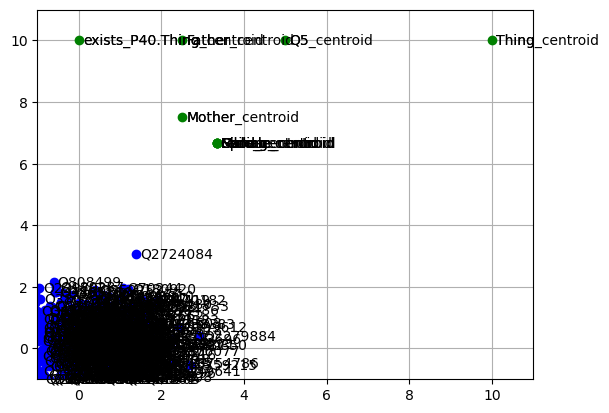

In [216]:
plot_model(model, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, SCALE_FACTOR)

In [222]:
EPOCHS = 500

Epoch 50/500 -> Train Loss: 7.1316 | Test Loss: 8.2599

Epoch 100/500 -> Train Loss: 6.9620 | Test Loss: 8.1403

Epoch 100: Initiating evaluation. 

Epoch 150/500 -> Train Loss: 6.8155 | Test Loss: 8.0312

Epoch 200/500 -> Train Loss: 6.6244 | Test Loss: 7.9302

Epoch 200: Initiating evaluation. 

Epoch 250/500 -> Train Loss: 6.4793 | Test Loss: 7.8381

Epoch 300/500 -> Train Loss: 6.3722 | Test Loss: 7.7537

Epoch 300: Initiating evaluation. 

Epoch 350/500 -> Train Loss: 6.2133 | Test Loss: 7.6772

Epoch 400/500 -> Train Loss: 6.1089 | Test Loss: 7.6085

Epoch 400: Initiating evaluation. 

Epoch 450/500 -> Train Loss: 6.0039 | Test Loss: 7.5465

Epoch 500/500 -> Train Loss: 5.9011 | Test Loss: 7.4903

Epoch 500: Initiating evaluation. 



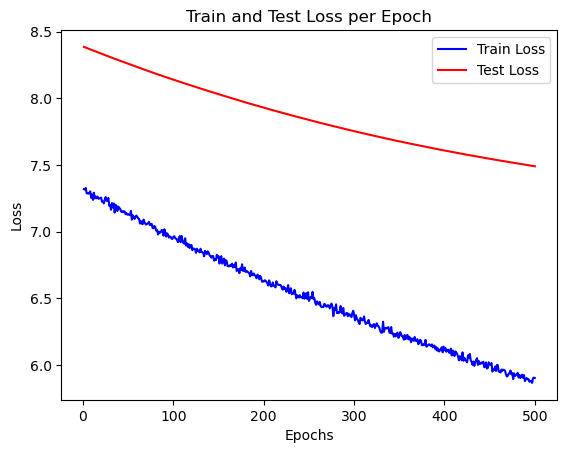

In [223]:
train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role, = train_model(model,
                                                                                                                                           train_ConceptDataLoader, train_RoleDataLoader, test_ConceptDataLoader, test_RoleDataLoader,
                                                                                                                                           trainConceptDataset, testConceptDataset, trainRoleDataset, testRoleDataset,
                                                                                                                                           EPOCHS, LOG_EPOCH, EVAL_FREQ, EVAL_TEST, loss_fn, optimizer,
                                                                                                                                           idx_to_entity_vocab, entity_to_idx_vocab,
                                                                                                                                           idx_to_concept_vocab, concept_to_idx_vocab,
                                                                                                                                           idx_to_role_vocab, role_to_idx_vocab,
                                                                                                                                           CENTROID_SCORE, ALT_TRAIN, PLOT_LOSS
                                                                                                                                           )

model_list.append(save_model(CENTROID_SCORE, LR, PHI, EMB_DIM, EPOCHS, LOG_EPOCH, EVAL_FREQ, EVAL_TEST, ALT_TRAIN, ENTITY_CENTROID_INIT, CONCEPT_CENTROID_INIT, ROLE_CENTROID_INIT,
                             loss_fn, model, optimizer, train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role))

In [224]:
# plot_model(model, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, SCALE_FACTOR)

In [227]:
# Without centroid score
pos_list = -1
TOPK = 1

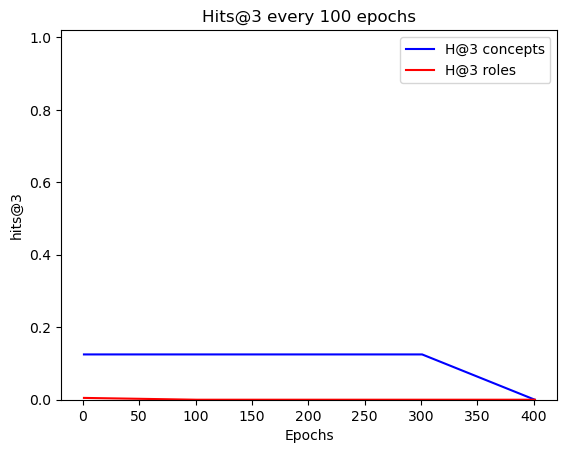

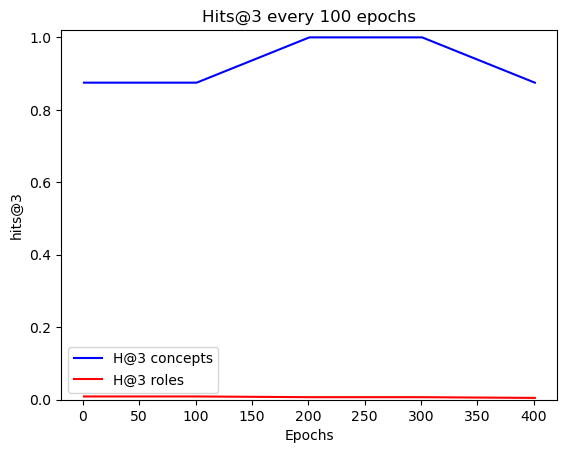

In [228]:
plot_score_hak(model_list[pos_list]['test_hits_at_k_concept'], model_list[pos_list]['test_hits_at_k_role'], TOPK, model_list[pos_list]['epochs'], model_list[pos_list]['eval_freq'])
plot_score_hak(model_list[pos_list]['train_hits_at_k_concept'], model_list[pos_list]['train_hits_at_k_role'], TOPK, model_list[pos_list]['epochs'], model_list[pos_list]['eval_freq'])

# Corruption for training with negative sampling

In [ ]:
def corrupt_concept_assertions(test_data_concept_assertions,
                               num_corrupt = int,
                               entity_to_idx_vocab = dict):

    candidate_entities = list(entity_to_idx_vocab.keys())
    
    original_assertions = torch.tensor([sample[0] for sample, label in list(test_data_concept_assertions)]) # Gets rid of the individual

    num_samples = len(original_assertions)

    sampled_entities = torch.tensor([torch.tensor(entity_to_idx_vocab[random.choice(candidate_entities)], dtype=torch.long) for _ in range(num_samples)])

    corrupted_assertions = torch.zeros((num_samples, 2), dtype=torch.long)
    corrupted_assertions[:, 0] = original_assertions
    corrupted_assertions[:, 1] = sampled_entities

    return corrupted_assertions

In [ ]:
def corrupt_role_assertions(test_data_role_assertions,
                            num_corrupt = int,
                            entity_to_idx_vocab=dict):

    candidate_entities = list(entity_to_idx_vocab.keys())

    original_head_entities = torch.tensor([sample[0] for sample, label in list(test_data_role_assertions)])
    original_roles = torch.tensor([sample[1] for sample, label in list(test_data_role_assertions)])
    original_tail_entities = torch.tensor([sample[2] for sample, label in list(test_data_role_assertions)])

    num_samples = len(original_head_entities)

    sampled_entities = torch.tensor([torch.tensor(entity_to_idx_vocab[random.choice(candidate_entities)], dtype=torch.long) for _ in range(num_samples)])

    corrupted_assertions = torch.zeros((num_samples, 3), dtype=torch.long)
    corrupted_assertions[:, 0] = original_head_entities # The original head entities
    corrupted_assertions[:, 1] = original_roles # The original roles
    corrupted_assertions[:, 2] = sampled_entities

    return corrupted_assertions